# One-Dimensional Climate Models: The Basics of Planets

In this tutorial you will learn the very basics of running 1D climate runs. For a more in depth look at the climate code check out [Mukherjee et al. 2022](https://ui.adsabs.harvard.edu/abs/2023ApJ...942...71M/abstract) (note this should also be cited if using this code/tutorial).

What you should already be familiar with:

- [basics of running/analyzing thermal spectra](https://natashabatalha.github.io/picaso/tutorials.html#basics-of-thermal-emission)
- [how to analyze thermal emission spectra](https://natashabatalha.github.io/picaso/notebooks/workshops/ERS2021/ThermalEmissionTutorial.html)
- [how to compute a Brown Dwarf 1D climate model](https://natashabatalha.github.io/picaso/notebooks/climate/12a_BrownDwarf.html)


What you will need to download to use this tutorial:

1. [Download](https://doi.org/10.5281/zenodo.18636725) New 1460 PT, 196 wno Correlated-k Tables to be used by the climate code for opacity (if you completed the brown dwarf tutorial you should already have this)
2. Download the PHOENIX stellar models.

You can easily do this with the `get_data` function


 >> import picaso.data as d

 >>d.get_data(category_download='ck_tables',target_download='by-molecule')

  >>d.get_data(category_download='stellar_grids',target_download='phoenix')


**Note**: the two files above are dependent on metallicity and C/O.

In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
import picaso.justdoit as jdi
import picaso.justplotit as jpi
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#1 ck tables from roxana
mh = '1.0'#'+1.0' #log metallicity, 10xSolar
CtoO = '0.46'#'1.0' # CtoO ratio, Solar C/O

ck_db = os.path.join(os.getenv('picaso_refdata'),'opacities', 'preweighted', f'sonora_2121grid_feh{mh}_co{CtoO}.hdf5')

In [3]:
# Notice The keyword ck is set to True because you want to use the correlated-k opacities for your calculation
# and not the line by line opacities
opacity_ck = jdi.opannection(ck_db=ck_db,method='preweighted') # grab your opacities

## Starting up the Run


You will notice that starting a run is nearly identical as running a spectrum and brown dwarf climate model. However, how we will add `climate=True` to our inputs flag. We will also specify `planet` in this case, which will turn on the irradiation the object is receiving.

New Parameter (was also used in the Brown Dwarf tutorial): **Effective Temperature**. This excerpt from [Modeling Exoplanetary Atmospheres (Fortney et al)](https://arxiv.org/pdf/1804.08149.pdf) provides a thorough description and more reading, if you are interested.

> If the effective temperature, $T_{eff}$, is defined as the temperature of a blackbody of
the same radius that would emit the equivalent flux as the real planet, $T_{eff}$ and $T_{eq}$
can be simply related. This relation requires the inclusion of a third temperature,
$T_{int}$, the intrinsic effective temperature, that describes the flux from the planet’s
interior. These temperatures are related by:

> $T_{eff}^4 =  T_{int}^4 + T_{eq}^4$

> We then recover our limiting cases: if a planet is self-luminous (like a young giant
planet) and far from its parent star, $T_{eff} \approx  T_{int}$; for most rocky planets, or any
planets under extreme stellar irradiation, $T_{eff} \approx T_{eq}$.

In [4]:
cl_run = jdi.inputs(calculation="planet", climate = True) # start a calculation

#note you need to put the climate keyword to be True in order to do so
# now you need to add these parameters to your calculation


tint= 200 # Intrinsic Temperature of your Planet in K
grav = 4.5 # Gravity of your Planet in m/s/s

cl_run.gravity(gravity=grav, gravity_unit=u.Unit('m/(s**2)')) # input gravity
cl_run.effective_temp(tint) # input effective temperature

Let's now input the host-star properties

In [5]:
T_star =5326.6 # K, star effective temperature
logg =4.38933 #logg , cgs
metal =-0.03 # metallicity of star
r_star = 0.932 # solar radius
semi_major = 0.0486 # star planet distance, AU

cl_run.star(opacity_ck, temp =T_star,metal =metal, logg =logg, radius = r_star,database='phoenix',
            radius_unit=u.R_sun,semi_major= semi_major , semi_major_unit = u.AU)

## Initial T(P)  Guess

Every calculation requires an initial guess of the pressure temperature profile. The code will iterate from there to find the correct solution. A few tips:

1. We recommend **using typically 51-91 atmospheric pressure levels**. Too many pressure layers increases the computational time required for convergence. Too little layers makes the atmospheric grid too coarse for an accurate calculation.

2. Start with **a guess that is close to your expected solution**. One easy way to get fairly close is by using the Guillot et al 2010 temperature-pressure profile approximation


In [6]:
nlevel = 91 # number of plane-parallel levels in your code

#Lets set the max and min at 1e-4 bars and 500 bars
Teq=1000 # planet equilibrium temperature
pt = cl_run.guillot_pt(Teq, nlevel=nlevel, T_int = tint, p_bottom=2, p_top=-6)
temp_guess = pt['temperature'].values
pressure = pt['pressure'].values

## Initial Convective Zone Guess

You also need to have a crude guess of the convective zone of your atmosphere. Generally the deeper atmosphere is always convective. Again a good guess is always the published SONORA grid of models for this. But lets assume that the bottom 7 levels of the atmosphere is convective.

**New Parameters:**

1. `rfacv`: (See Mukherjee et al Eqn. 20 `r_st`) https://arxiv.org/pdf/2208.07836.pdf

Non-zero values of rst (aka "rfacv" legacy terminology) is only relevant when the external irradiation on the atmosphere is non-zero. In the scenario when a user is computing a planet-wide average T(P) profile, the stellar irradiation is contributing to 50% (one hemisphere) of the planet and as a result rst = 0.5. If instead the goal is to compute a night-side average atmospheric state, rst is set to be 0. On the other extreme, to compute the day-side atmospheric state of a tidally locked planet rst should be set at 1.

In [7]:
rcb_guess = 85 # top most level of guessed convective zone

# Here are some other parameters needed for the code.
rfacv = 0.5 #we are focused on a brown dwarf so let's keep this as is

Now we would use the inputs_climate function to input everything together to our cl_run we started.

In [8]:
cl_run.inputs_climate(temp_guess= temp_guess, pressure= pressure,
                      rcb_guess=rcb_guess, rfacv = rfacv)

## Run the Climate Code

 The actual climate code can be run with the cl_run.run command. The save_all_profiles is set to True to save the T(P) profile at all steps. The code will now iterate from your guess to reach the correct atmospheric solution for your brown dwarf of interest.



In [9]:
out = cl_run.climate(opacity_ck, save_all_profiles=True,with_spec=True)

SUMMARY
-------
Clouds: False
quench False
cold_trap False
vol_rainout False
no_ph3 False
Moist Adiabat: False


Iteration number  0 , min , max temp  857.891950050302 2293.489765369266 , flux balance  0.24586805323301847
Iteration number  1 , min , max temp  825.5532298480927 2768.9875908947215 , flux balance  15.468720921315139
Iteration number  2 , min , max temp  823.463745745593 2648.9650134030294 , flux balance  0.2722544197601914


Iteration number  3 , min , max temp  823.4446145455615 2635.5916060601194 , flux balance  0.0014843772530978212
Iteration number  4 , min , max temp  823.4445103063792 2635.404319771508 , flux balance  7.539558433178064e-06
In t_start: Converged Solution in iterations  4
Big iteration is  823.4445103063792 0
 We are already at a root, tolf , test =  5e-05 ,  1.1417209376238072e-05
Profile converged before itmx


Iteration number  0 , min , max temp  819.7214913162957 2726.6998607756836 , flux balance  1.1003740239657238
Iteration number  1 , min , max temp  814.7326382540977 2817.7498481275484 , flux balance  0.19705910074854008
Iteration number  2 , min , max temp  814.6622197922778 2812.6537509788036 , flux balance  0.0011923310664987655
In t_start: Converged Solution in iterations  2
Big iteration is  814.6622197922778 0


Iteration number  0 , min , max temp  814.6618396151556 2812.625425336018 , flux balance  6.500053131255152e-06
In t_start: Converged Solution in iterations  0
Profile converged before itmx


Iteration number  0 , min , max temp  809.5097543297865 2830.5744748896304 , flux balance  0.016850644665374438
Iteration number  1 , min , max temp  809.4356579198734 2828.883009091387 , flux balance  0.00010682290897799364
In t_start: Converged Solution in iterations  1
Big iteration is  809.4356579198734 0


Iteration number  0 , min , max temp  809.4352624844934 2828.877031509815 , flux balance  6.312766194081936e-07
In t_start: Converged Solution in iterations  0
Profile converged before itmx


Iteration number  0 , min , max temp  807.6049245392105 2811.4052984988853 , flux balance  0.0012432801842257157
In t_start: Converged Solution in iterations  0
Big iteration is  807.6049245392105 0


Iteration number  0 , min , max temp  807.5893131192433 2811.394403395632 , flux balance  8.215615786276766e-06
In t_start: Converged Solution in iterations  0
Profile converged before itmx
final [0, 83, 89, 0, 0, 0]


Iteration number  0 , min , max temp  807.6827329802513 2812.520240725085 , flux balance  0.0002390937769113331
In t_start: Converged Solution in iterations  0
Big iteration is  807.6827329802513 0


Iteration number  0 , min , max temp  807.6831742227286 2812.5223251233124 , flux balance  1.3892854960271714e-06
In t_start: Converged Solution in iterations  0
Profile converged before itmx
YAY ! ENDING WITH CONVERGENCE


Text(0.5, 1.0, 'T$_{\\rm eff}$= 1000 K, log(g)=5.0')

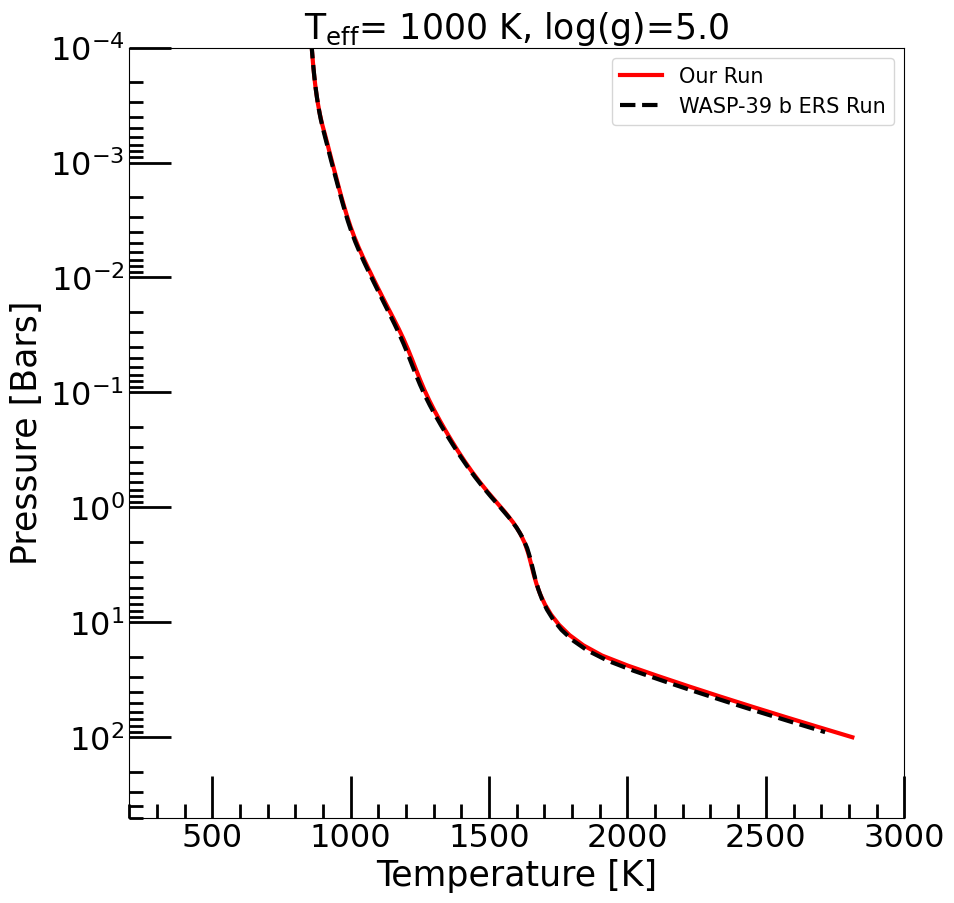

In [10]:
base_case = jdi.pd.read_csv(jdi.HJ_pt(), sep=r'\s+')

plt.figure(figsize=(10,10))
plt.ylabel("Pressure [Bars]", fontsize=25)
plt.xlabel('Temperature [K]', fontsize=25)
plt.ylim(500,1e-4)
plt.xlim(200,3000)

plt.semilogy(out['temperature'],out['pressure'],color="r",linewidth=3,label="Our Run")

plt.semilogy(base_case['temperature'],base_case['pressure'],color="k",linestyle="--",linewidth=3,label="WASP-39 b ERS Run")


plt.minorticks_on()
plt.tick_params(axis='both',which='major',length =30, width=2,direction='in',labelsize=23)
plt.tick_params(axis='both',which='minor',length =10, width=2,direction='in',labelsize=23)

plt.legend(fontsize=15)

plt.title(r"T$_{\rm eff}$= 1000 K, log(g)=5.0",fontsize=25)



### Brightness Temperature

Checking the brightness temperature serves many useful purposes:

1. Intuition building. Allows you to see what corresponding temperature are you sensitive to at each wavelength

Note that this temperature doesn't need to be the physical temperature of your atmosphere but if you can find the physical converged atmospheric temperature closest to this brightness temperature you can also get an idea of the atmospheric pressure from where the flux you are seeing is originating from.

2. Determining if your choice in bottom boundary pressure grid was correct.

If your brightness temperature is such that you bottom out at the temperature corresponding to the highest pressure, you have not extended your grid to high enough pressures.

Brightness Temperature Equation:

$T_{\rm bright}=\dfrac{a}{{\lambda}log\left(\dfrac{{b}}{F(\lambda){\lambda}^5}+1\right)}$

where a = 1.43877735$\times$10$^{-2}$ m.K and b = 11.91042952$\times$10$^{-17}$ m$^4$kg/s$^3$

Let's calculate the brightness temperature of our current run and check if our pressure grid was okay.

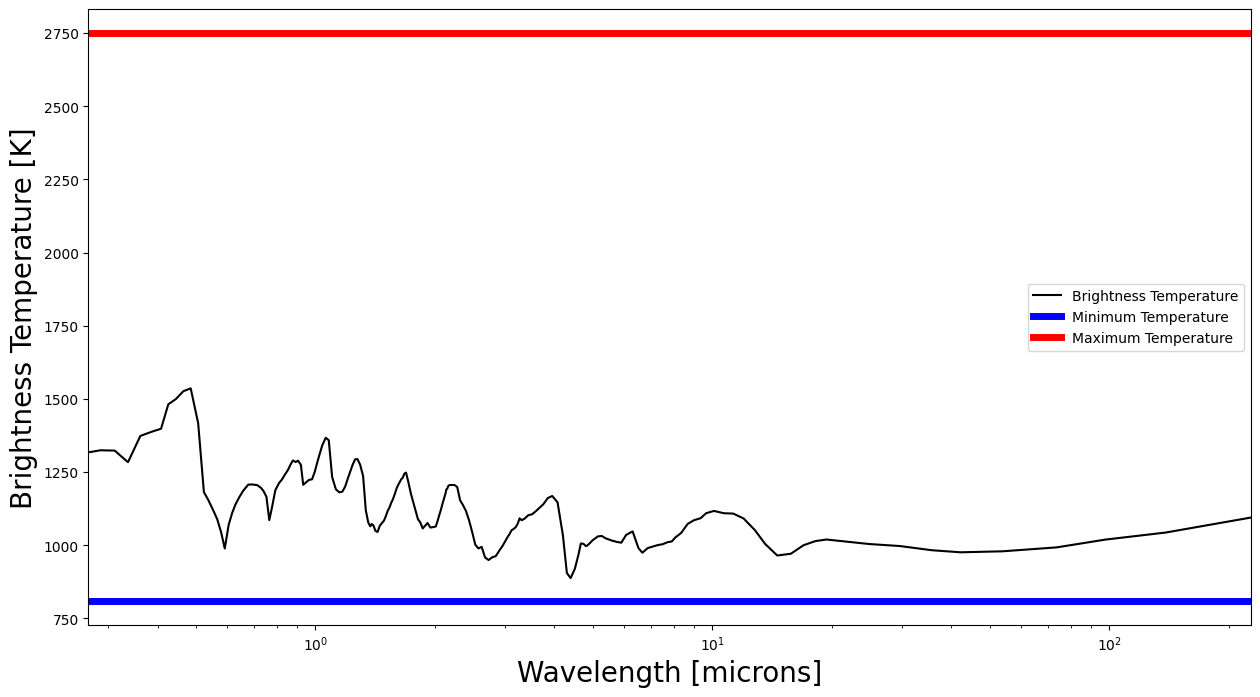

In [11]:
brightness_temp, figure= jpi.brightness_temperature(out['spectrum_output'])

### Check Adiabat

This plot and datareturn is helpful to check that there have been no issues with where the code has found the location of the convective zone(s). See below, dTdP never exceeds the adiabat.

In [12]:
import importlib;importlib.reload(jpi)

<module 'picaso.justplotit' from '/home/nbatalh1/codes/picaso/picaso/justplotit.py'>

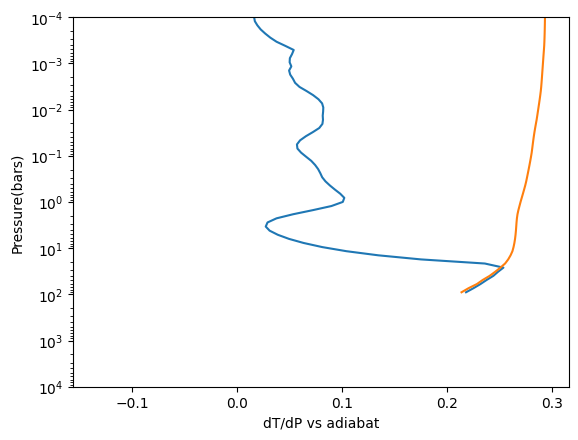

In [13]:
cp, adiabat, dtdp, pressure = jpi.pt_adiabat(out, cl_run, opacity_ck, plot=True)

In [14]:
jdi.output_xarray(out,cl_run,savefile='w39.nc')

<xarray.Dataset> Size: 59kB
Dimensions:         (pressure: 91, pressure_layer: 90, wavelength: 196)
Coordinates:
  * pressure        (pressure) float64 728B 1e-06 1.227e-06 ... 81.49 100.0
  * pressure_layer  (pressure_layer) float64 720B 1.108e-06 1.359e-06 ... 90.27
  * wavelength      (wavelength) float64 2kB 227.5 138.8 97.75 ... 0.287 0.2679
Data variables: (12/76)
    temperature     (pressure) float64 728B 857.0 833.6 ... 2.69e+03 2.813e+03
    dtdp            (pressure_layer) float64 720B -0.1351 -0.06234 ... 0.2181
    guess 1         (pressure) float64 728B 861.5 861.5 ... 1.876e+03 1.933e+03
    guess 2         (pressure) float64 728B 861.5 861.5 ... 2.114e+03 2.226e+03
    guess 3         (pressure) float64 728B 861.5 861.5 ... 2.114e+03 2.226e+03
    guess 4         (pressure) float64 728B 861.5 859.6 ... 2.18e+03 2.293e+03
    ...              ...
    Mg+             (pressure) float64 728B 3.456e-41 4.021e-43 ... 2.753e-10
    Si              (pressure) float64 728B 6.984e-32 1.829e-33 ... 5.969e-07
    Fe+             (pressure) float64 728B 4.405e-39 7.155e-41 ... 6.194e-11
    Ti              (pressure) float64 728B 8.889e-35 1.975e-36 ... 8.604e-08
    Ti+             (pressure) float64 728B 1e-50 1e-50 ... 3.606e-13 1.151e-12
    C+              (pressure) float64 728B 1e-50 1e-50 ... 2.024e-25 3.293e-24
Attributes:
    climate_params:  {"cvs_locs": [0, 83, 89, 0, 0, 0], "converged": 1}
    planet_params:   {"effective_temp": 1087.1215242417622, "gravity": {"valu...
    stellar_params:  {"database": "phoenix", "steff": 5326.6, "feh": -0.03, "...
    orbit_params:    {"sma": {"value": 727045651602.0, "unit": "cm"}}